<a href="https://colab.research.google.com/github/elliotpaquette/elliotpaquette/blob/master/MNISTGeneralization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this file**, we derive predictions for the training and testing of a random features regression for even/odd prediction in MNIST.


In [ ]:
import numpy as np
import scipy as sp
from scipy.sparse import linalg as splinalg
from scipy.signal import fftconvolve as fftconvolve
from scipy.integrate import quad
from scipy.integrate import solve_ivp

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [ ]:
def sgd_lsq_ridge( A, b, t_max, ridge=0.0, 
             initial_state = [], loss=lambda x: (1/2)*np.sum( (A@x-b)**2), 
             gamma=-1, oversample=1, m=1.0):
  """Runs the sDANA algorithm to solve the least squares problem Ax=b.
  The special case of gamma_1 =0 recovers SGD.

  Parameters
  ----------
  A : matrix
      The data matrix (2d-array) of some shape (n,d)
  b : vector
      The target vector
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  ridge : float, optional
      The strength of the ridge regularization
  initial_state : vector, optional
      The initial state vector of the algorithm.  Defaults to 
      iid Gaussian of expected norm-squared d/(2*n).
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  ridge: float, optional
      The ridge parameter to pass.
  oversample: int, optional
      return additional losses, by a multiple of oversample 
      (note integer division is performed, so every n//oversample is returned)
  m: float, optional
      The adaptive step parameter.
  

  Returns
  -------
  t_grid: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  """

  n, d = A.shape
  adaptivestep=False
  TL = lambda x: (1/2)*np.sum( (A@x-b)**2)

  if gamma==-1:
    gamma = n/np.linalg.norm(A)**2
  if gamma=='adaptive':
    adaptivestep = True
    gamma = n/np.linalg.norm(A)**2
    Gamma=0
    


  steps = int(n * t_max)
  
  losses = []
  gammas = []

  if (len(initial_state)==0):
    initial_state = np.random.randn(d)/ (np.sqrt(2*n))
  x = initial_state  

  tnaught = TL(x)

  for t in range(steps):
    i = np.random.randint(0,n, size =1)[0]
    grad_i = A[i] * (A[i].dot(x) - b[i]) + (ridge / n) * x
    if t % (n//oversample) == 0:
      losses.append(loss(x))
    if (adaptivestep) and (t % n == 0):
      Gamma += gamma
      tz = TL(x)
# This adaptive stepsize is the other solution of the variational problem
#      gamma = 1./(np.exp(Gamma * (m+ridge)*0.666)*np.power(tz/tnaught,0.333))
      gamma = 2./(0.75 + np.sqrt(0.5625 + np.exp(2*Gamma * (ridge+m))*tz/tnaught))
      gammas.append(gamma)
    x = x - gamma * grad_i
  if (adaptivestep):
    return x, np.array(losses), np.array(gammas)
  return x, np.array(losses)

In [ ]:
def picard_volterra(f, K, t_max, n_grid):
  """Runs Picard iteration to approximate a convolution Volterra equation
  sol = f + K*sol, where * denotes convolution, 
  and where K is assumed to be positive.

  Parameters
  ----------
  f : callable
      Forcing function that takes as input a vector of times to be evaluated
  K : callable
      Convolution kernel that takes as input a vector of times to be evaluated
  t_max : float
      The number of epochs 
  n_grid : int
      The number of grid points

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """

  t_grid = np.linspace(0, t_max, n_grid)
  delta = t_max/n_grid
  I = delta*K(t_grid)
  F = f(t_grid)

  for i in range(n_grid):
    if I[i] > 0.001 and (i+1) < n_grid:
      #if i% 10 == 0:
      #  print("Using quadrature to refine kernel with t="+str(t_grid[i])+" as kernel output="+str(I[i]))
      I[i] = quad(K, t_grid[i], t_grid[i+1])[0]
  
  knorm = np.sum(I)
  print( "kernel norm computed as "+str(knorm))

  loops = int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  sol = np.zeros(n_grid)
  for i in range(loops):
    sol = F + fftconvolve(sol, I, mode="full")[0:n_grid]
  return t_grid, sol
  

In [ ]:
from gc import is_tracked
def empirical_volterra_sgd(eiglist, t_max, n_grid, initial_state, UTb, ridge = 0.0, gamma=-1):
  """Generates the Volterra model for SGD for a list of eigenvalues eiglist

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T).
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of 
      the eigenvalues

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n_eig= len(eiglist)

  if gamma==-1:
    gamma = len(eiglist)/np.sum(eiglist)

  def K(t):
    def Ktwo(x,t):
      return (gamma**2)*(x**2)*np.exp(-2*gamma*(x+ridge)*t)
    ktally = 0
    return np.sum(np.array([np.real(Ktwo(eig,t)) for eig in eiglist]),axis=0)/n_eig

  def forcing(times):
    tmin = min(times)
    tmax = max(times)
    ftally = np.zeros_like(times)
    n = n_eig
    d = len(initial_state)
    for (utb,eig,ist) in zip(UTb,eiglist,initial_state):
      ftally += 0.5*((ist**2)*eig)*np.exp(-2*gamma*(eig+ridge)*times)
      ftally += 0.5*(utb*(eig/(eig+ridge)*(1- np.exp(-gamma*(eig+ridge)*times)) - 1))**2
    if n > d:
      ftally += (0.5*np.sum(UTb[-(n-d):]**2))
    return ftally 

  t_grid, sol = picard_volterra(forcing,K,t_max,n_grid)

  return t_grid, sol



Demonstrate the empirical losses of the Volterra equation with empirical eigenvalues vs sgd on random features data.

Given Gaussian vectors X (''data'') ($n \times n_0$ -- n samples of data dimension $n_0$, which are standardized), we multiply by a weight matrix W (''inner layer weights'') ($n_0 \times d$ -- un-normalized).  Then $XW$ is $n \times d$.  We apply an activation function $\psi$ to each entry of $XW$.  We assume that $\psi$ is also standarized, in that $\mathbb{E}( \psi(Z) ) =0$ and  $\mathbb{E}( \psi(Z)^2 ) = 1/d$ for $Z \sim N(0,1).$

Example (1):
The linear case is $\psi(x) = x/\sqrt{d}$.

Example (2):
The ReLU case is $\frac{(\max\{x,0\} - (1/\sqrt{2\pi}))}{\sqrt{d}\sqrt{ 1/2 - 1/(2\pi)}}$

The ground truth is a linear model $x \mapsto x^T\beta$ for $x \in \mathbb{R}^{n_0}$ and $\beta \in \mathbb{R}^{n_0}$.  We suppose that $\beta$ are iid $N(0,1)$.  Then we draw a $b = X \beta$.

The first cell below generates the sample covariance matrix and the sample mean needed to to evaluate the test error.


In [ ]:
def stdz_relu(M):
  """Generate a gaussian-mean-0, gaussian-variance-1 relu of a matrix
  Parameters
  ----------
  M : vector
      The data to be relued
  """    
  return (np.maximum(M,0.0)-(1.0/np.sqrt(2*np.pi)))/np.sqrt(0.5 - 1.0/(2*np.pi))

def ReLU_sigma_psi(W, samples=16000):
  """Generate the sample covariance matrix and the empirical mean (see eq (8))
  ----------
  W : matrix
      The weight matrix 
  samples: integer or matrix
      If integer, the number of Gaussian samples. Otherwise, a standardized matrix of data
  """    
  (n_0, d) = W.shape
  scov = np.zeros((d,d))
  psihat = np.zeros((n_0,d))
  
  if type(samples) == np.ndarray:
    Xi=samples
    samples = Xi.shape[0]
  else:
    Xi = np.random.randn(samples,n_0)/np.sqrt(n_0)
  Ai = stdz_relu(Xi@W)/np.sqrt(d)
  scov = Ai.transpose()@Ai
  psihat = Xi.transpose()@Ai

  return scov/samples, psihat/samples

The routine below simulates the generalization error.

In [ ]:
def empirical_volterra_g_sgd(eiglist, t_max, n_grid, initial_state, UTb,
                             S,h,c, 
                             ridge = 0.0, gamma=-1
                             ):
  """Generates the generalization error in the Volterra model for SGD, with parameters
  given in the spectral basis

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T), in DECREASING ORDER.
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  S,h,c: matrix,vector,float
      The S,h,c are the terms in the generalization functional, g, such that
      g(V^T x_t) = 0.5*x_t^T V S V^T x_t + h^T V^T x_t + c (see eq (104))
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of 
      the eigenvalues

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the generalization error at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n = len(eiglist)
  d = len(initial_state)

  if gamma==-1:
    gamma = n/np.sum(eiglist)

  t_grid, f1 = empirical_volterra_sgd(eiglist,t_max,n_grid,initial_state,UTb,ridge,gamma)
  
  eiglist = np.pad(eiglist, (0,max(d-n,0)))
  eiglist = eiglist[0:d]
  UTb = np.pad(UTb, (0,max(d-n,0)))
  UTb = UTb[0:d]

  L = np.linalg.cholesky(S + 1E-06*np.identity(d))
  EM = [np.exp(-gamma*(x+ridge)*t_grid) for x in eiglist]
  SUTb = UTb * np.sqrt(eiglist) / (eiglist + ridge+1E-08)
  EM1 = (np.ones((d,n_grid)) - EM)

  # ||x_0 * EM(t) * L||^2
  l1 = 0.5*np.sum(np.einsum('i,ij,ik', initial_state, EM, L)**2,axis=1)

  # ||SUTb^T * EM1(t) * L||^2
  l2 = 0.5*np.sum(np.einsum('i,ij,ik', SUTb, EM1, L)**2,axis=1)

  # SUTb^T * EM1(t) * h
  l3 = np.einsum('i,ij,i', SUTb, EM1, h)

  #This is the convolution term, the final in (104).  We had a trapezoid rule correction.
  igrand = np.sum([s*x*np.exp(-2*gamma*(x+ridge)*t_grid) for (s,x) in zip(np.diag(S),eiglist)],axis=0)
  igrand = igrand * (gamma**2/n) * (t_max/(n_grid+1))
  l4 = fftconvolve(igrand, f1, mode="full")[0:n_grid] + (
      -0.5*igrand[0]*f1
      -0.5*igrand*f1[0]
  )


  gerror = l1+l2+l3+l4+c

  return t_grid, gerror

  #Implement the trapezoid rule to numerically integrate the diffG
  #G = np.cumsum(diffG)*t_max/n_grid + (
  #    -1*diffG/2*(t_max/n_grid) + 
  #    -1*diffG[0]/2*(t_max/n_grid) +
  #    +np.sum(Rlist)/n_eig
  #)


MNIST Experiments.

Tested on n=1000,2000,4000,8000.

Simple linear regression to predict even/odd

11501568/11490434 [==============================] - 0s 0us/step


KeyboardInterrupt: ignored

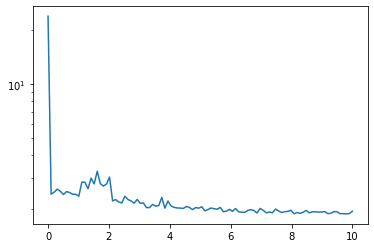

In [ ]:
d = 28*28
n = 16000
n_grid = 1000

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
#flat = flat.reshape(60000,d)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)


A = rescaled_flat[0:n]
b = (y_train[0:n] % 2 - 0.5)
invnorms=sp.sparse.diags(1/np.linalg.norm(A,axis=1))
A = invnorms@A
b = invnorms@b

#Anorm= np.linalg.norm(A)**2

t_max = 10

gamma=0.2
ridge = 0.1
os=10
ist = np.ones(d)/np.sqrt(n)

#( A, b, t_max, ridge=0.0, 
#             initial_state = [], loss=lambda x: (1/2)*np.sum( (A@x-b)**2), 
#             gamma=-1,oversample=1):
# sgd_sol, sgd_train = sgd_lsq_ridge(A,b,t_max,ridge=ridge,initial_state=ist,gamma=gamma,oversample=4)
sgd_sol, sgd_train, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,initial_state=ist,gamma='adaptive',oversample=os)

plt.yscale('log')
plt.plot(np.linspace(0,t_max,t_max*os), sgd_train, label="MNIST SGD Training (adaptive-step)")

#eigs, U = np.linalg.eigh(A@A.transpose())
U, s, Vh = np.linalg.svd(A, full_matrices=True)
eigs = np.pad(s**2, (0,max(n-d,0)))

UTb = U.transpose() @ b
#UTb = np.pad(UTb,(0,max(n-d,0)))

#eiglist, t_max, n_grid, R, UTb, ridge = 0.0, gamma=-1)
t_grid, v_emp = empirical_volterra_sgd(eigs,t_max,n_grid,Vh@ist,UTb,ridge,gamma)
plt.plot(t_grid, v_emp, label="Empirical Volterra (constant-step)")
plt.legend()

In [ ]:
flat_test = x_test.reshape(10000,28*28)
flat_test =scaler.transform(flat_test)

prediction = (flat_test @ sgd_sol)
bool_pre = prediction > 0
actual = (y_test[0:10000] % 2) > 0

print("Correctly predicted " + str(np.sum((bool_pre == actual)/10000)))

Correctly predicted 0.8823000000000003


MNIST random features regression for even/odd.

kernel norm computed as 0.050277816367421894
will use 4 iterations
kernel norm computed as 0.10038935486841022
will use 5 iterations
kernel norm computed as 0.2004218584266284
will use 6 iterations
kernel norm computed as 0.4003700297842158
will use 11 iterations


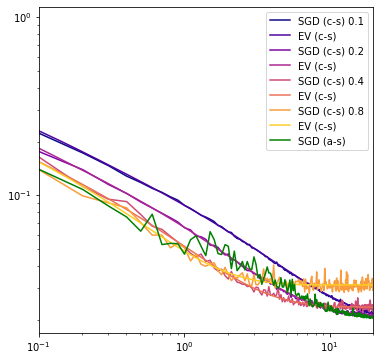

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 16000 #datapoints to keep
t_max = 20
gamma_list = [0.1,0.2,0.4,0.8]
ridge = 0.01
os=10 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)

X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = np.random.randn(n0,d)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))

UTb = U.transpose() @ b
knorm = np.sqrt(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2)
if n > d: 
  UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )


fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(gamma_list))))

for gamma in gamma_list:
  sgd_sol, sgd_train_cs = sgd_lsq_ridge(A,b,t_max,ridge=ridge,initial_state=ist,gamma=gamma,oversample=os)
  plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_cs, label="SGD (c-s) "+str(gamma),
           c=next(colors))
  t_grid, v_emp = empirical_volterra_sgd(eigs,t_max,n_grid,Vh@ist,UTb,ridge,gamma)
  plt.plot(t_grid, v_emp, label="EV (c-s)",c=next(colors))


sgd_sol, sgd_train_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_as, label="SGD (a-s)",c='green')

plt.xlim([0.1,t_max])
plt.legend()

MNIST Validation Test error

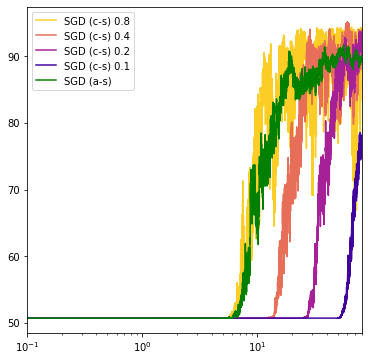

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 16000 #datapoints to keep
t_max = 80
gamma_list = [0.8,0.4,0.2,0.1]
ridge = 0.01
os=100 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)
b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)



X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = np.random.randn(n0,d)

flat_test = x_test.reshape(10000,28*28)
flat_test =scaler.transform(flat_test)
actual = (y_test[0:10000] % 2) > 0
TA = (stdz_relu(flat_test@W)/np.sqrt(d))
testloss=lambda x: (np.sum(((TA@ x) > 0) == actual)/100)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))

UTb = U.transpose() @ b
knorm = np.sqrt(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2)
if n > d: 
  UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )


testfig = plt.figure(figsize=(6, 6))
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0.9, 0.1, len(gamma_list))))

for gamma in gamma_list:
  sgd_sol, sgd_test_cs = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                        loss = testloss,
                                        initial_state=ist,gamma=gamma,oversample=os)
  plt.plot(np.linspace(0,t_max,t_max*os), sgd_test_cs, label="SGD (c-s) "+str(gamma),
           c=next(colors))
  #t_grid, v_emp = empirical_volterra_sgd(eigs,t_max,n_grid,Vh@ist,UTb,ridge,gamma)
  #plt.plot(t_grid, v_emp, label="EV (c-s)",c=next(colors))


sgd_sol, sgd_test_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                          loss=testloss,
                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
plt.plot(np.linspace(0,t_max,t_max*os), sgd_test_as, label="SGD (a-s)",c='green')

plt.xlim([0.1,t_max])
plt.legend()

In [ ]:
max(sgd_test_as)

96.08

MNIST L2 test error, with Volterra comparison

kernel norm computed as 0.05036660432733887
will use 4 iterations
kernel norm computed as 0.10056772540241225
will use 5 iterations
kernel norm computed as 0.20077989530173163
will use 6 iterations
kernel norm computed as 0.40108352609113124
will use 11 iterations


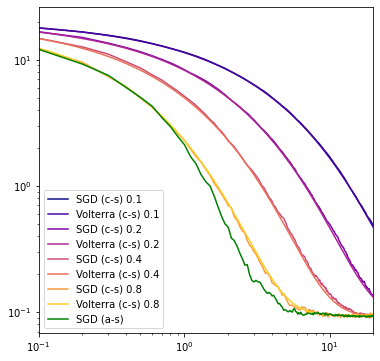

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 16000 #datapoints to keep
t_max = 20
n_grid=1000
gamma_list = [0.1,0.2,0.4,0.8]
ridge = 0.01
os=10 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)

X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = np.random.randn(n0,d)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

#Compute eigendecomposition of target
U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))
eigs = eigs[0:n]

UTb = U.transpose() @ b
knorm = np.sqrt(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2)
if n > d: 
  UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

#initialize figure
test2fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(gamma_list))))


#Compute test loss parameters
flat_test = x_test.reshape(10000,28*28)
flat_test =scaler.transform(flat_test)
actual = ((y_test[0:10000] % 2) - 0.5)/np.sqrt(10000)
TA = (stdz_relu(flat_test@W)/np.sqrt(d)/np.sqrt(10000))
SigmaPsi = TA.transpose() @ TA 
u=actual.transpose()@TA
c=0.5*np.sum(actual**2)
test2loss= lambda x: (1/2)*(x.transpose()@SigmaPsi@x)+c-u@x

#These are used for the volterra computation
S = Vh@SigmaPsi@Vh.transpose()
h = -Vh@u.transpose()

for gamma in gamma_list:
  sgd_test2_cs = sgd_lsq_ridge(A,b,t_max,ridge=ridge,initial_state=ist,
                          loss=test2loss,
                          gamma=gamma,
                          oversample=os)[1]
  plt.plot(np.linspace(0,t_max,t_max*os), sgd_test2_cs, label="SGD (c-s) "+str(gamma),
           c=next(colors))
  #Second way of getting the training loss, using the empirical_volterra_g_sgd
  t_grid, v_emp = empirical_volterra_g_sgd(eigs,t_max,n_grid,
                                           Vh@ist,UTb,S,h,c,ridge,
                                           gamma=gamma)
  plt.plot(t_grid, v_emp, label="Volterra (c-s) "+str(gamma),
           c=next(colors))

sgd_sol, sgd_test_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
                                          loss=test2loss,
                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
plt.plot(np.linspace(0,t_max,t_max*os), sgd_test_as, label="SGD (a-s)",c='green')

plt.xlim([0.1,t_max])
plt.legend()

In [ ]:
from google.colab import files
fig.savefig('MNIST_RF_SGD_Train_dXn_2kX16k_t20.pdf')
testfig.savefig('MNIST_RF_SGD_Validation_dXn_2kX16k_t20.pdf')
test2fig.savefig('MNIST_RF_SGD_L2Train_dXn_2kX16k_t20.pdf')
files.download('MNIST_RF_SGD_Train_dXn_2kX16k_t20.pdf')
files.download('MNIST_RF_SGD_Validation_dXn_2kX16k_t20.pdf')
files.download('MNIST_RF_SGD_L2Train_dXn_2kX16k_t20.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n = 4000 #datapoints to keep
t_max = 20
n_grid=1000
gamma_list = [0.1,0.2,0.4,0.8]
ridge = 0.01
os=10 #show os datapoints per epoch

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
flat = x_train.reshape(60000,28*28)
scaler = StandardScaler().fit(flat)
rescaled_flat =scaler.transform(flat)

b = (y_train[0:n] % 2 - 0.5)/np.sqrt(n)

X = rescaled_flat[0:n]
invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
X = invnorms@X
W = np.random.randn(n0,d)

#Data
A = stdz_relu(X@W)/np.sqrt(d)

#initialization
ist = np.ones(d)/np.sqrt(n)

#Compute eigendecomposition of target
U, s, Vh = np.linalg.svd(A, full_matrices=False)
eigs = np.pad(s**2, (0,max(n-d,0)))
eigs = eigs[0:n]

plt.hist(eigs[eigs>0.1],bins=100,density=True)
#a = eigs[eigs < 2]
#plt.plot(np.log(np.sort(a)), np.log(np.linspace(0, 1, len(a), endpoint=False)))


In [ ]:
print(min(s**2))
print(max(s**2))
print(np.sum(s**2)/4000.)

0.017536024372953835
295.62384684348035
1.0005804256469233
